#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

Загрузим данные и отсортируем

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data.sort_index(inplace=True)

In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


В данных нет пропусков или очевидных аномалий

In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


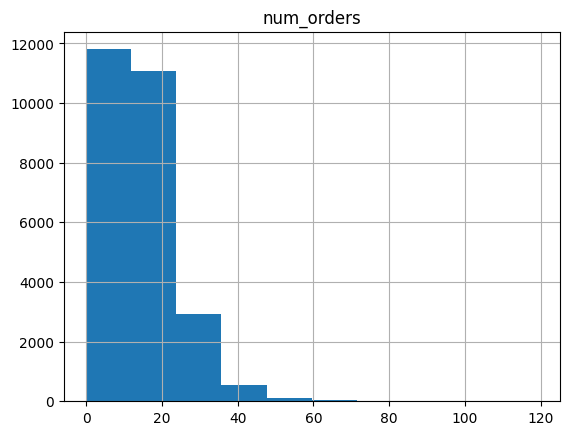

In [9]:
data.hist();

Сделаем ресемплирование по одному часу

In [10]:
data_res = data.resample('1H').sum()

Итог:
- Данные загружены
- Произведено ресемплирование по 1 часу

## Анализ

Рассмотрим сезонность и тренд данных

In [11]:
decomposed = seasonal_decompose(data_res)

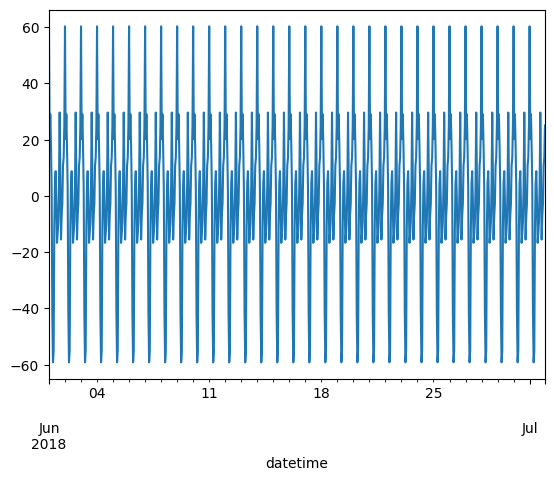

In [12]:
decomposed.seasonal['2018-06-01':'2018-07-01'].plot(ax=plt.gca());

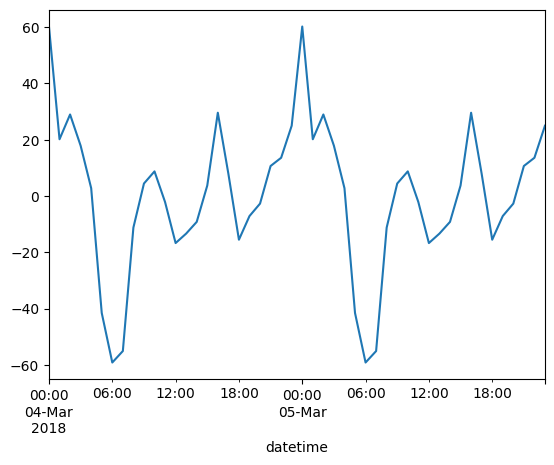

In [13]:
decomposed.seasonal['2018-03-04':'2018-03-05'].plot(ax=plt.gca());

Присутствует сезонность в течение суток

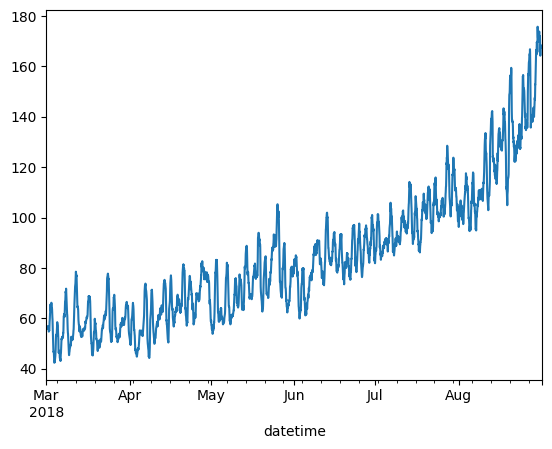

In [14]:
decomposed.trend.plot(ax=plt.gca());

Количество заказов увеличивается к осени

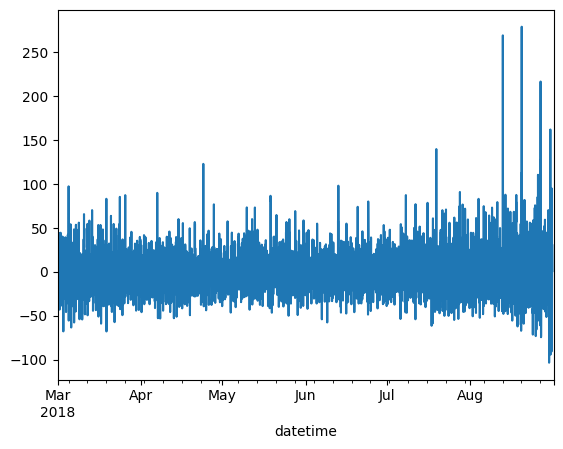

In [15]:
decomposed.resid.plot(ax=plt.gca());

Шум в данных сильнее для представленных после августа значений, что может повлиять на обучение модели

Рассмотрим скользящее среднее для разных промежутков времени

In [16]:
data_res['mean'] = data_res['num_orders'].rolling(24).mean()
data_res['std'] = data_res['num_orders'].rolling(24).std()

В соответствии с трендом скользящее среднее растет к осени

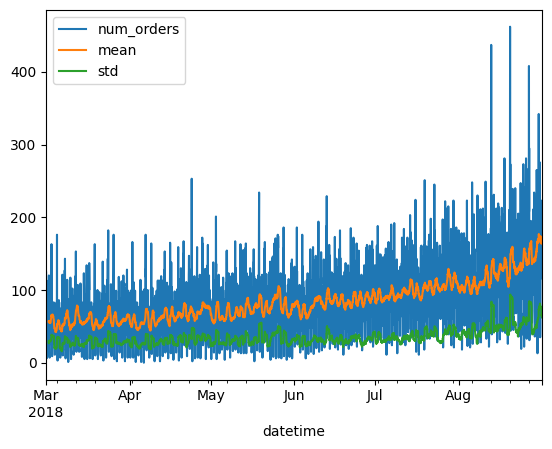

In [17]:
data_res.plot();

Есть колебания скользящего среднего от дня к дню, стоит рассмотреть зависимость целевого признака, например, от дня недели

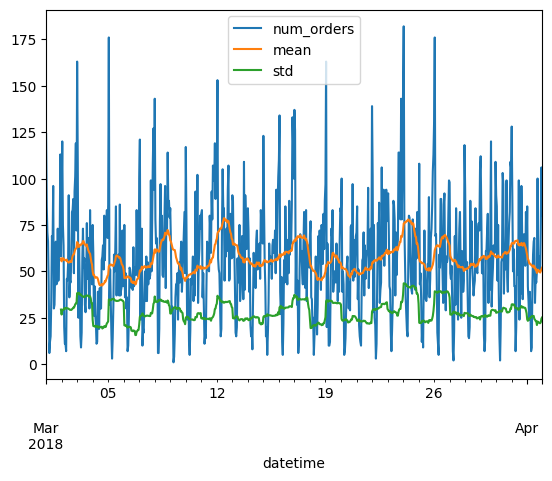

In [18]:
data_res['2018-03-01':'2018-04-01'].plot();

В течение дня скользящее среднее изменяется несильно

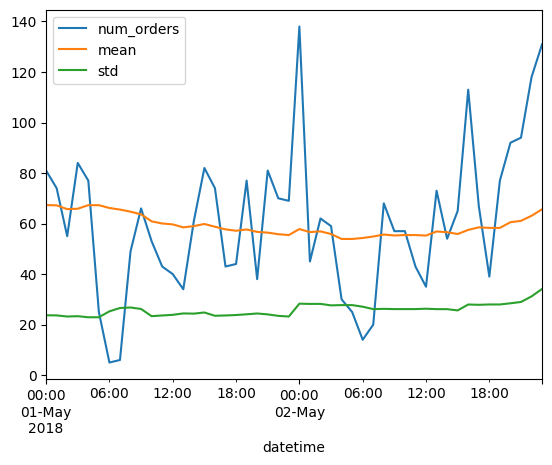

In [19]:
data_res['2018-05-01':'2018-05-02'].plot();

In [20]:
data_week = data.resample('1D').sum()

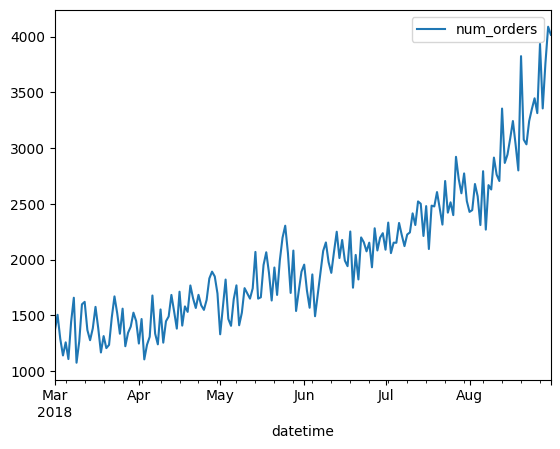

In [21]:
data_week.plot();

In [22]:
decomposed_week = seasonal_decompose(data_week)

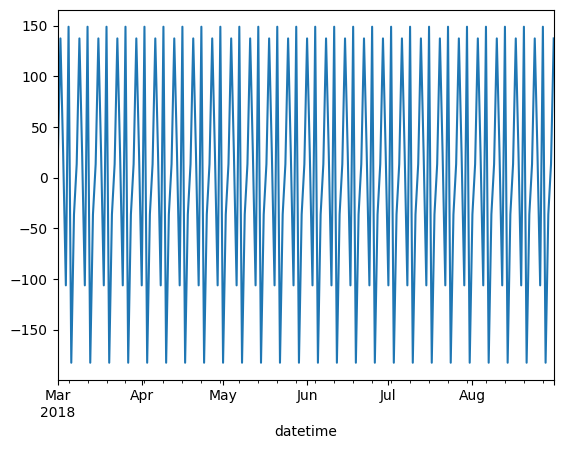

In [23]:
decomposed_week.seasonal.plot(ax=plt.gca());

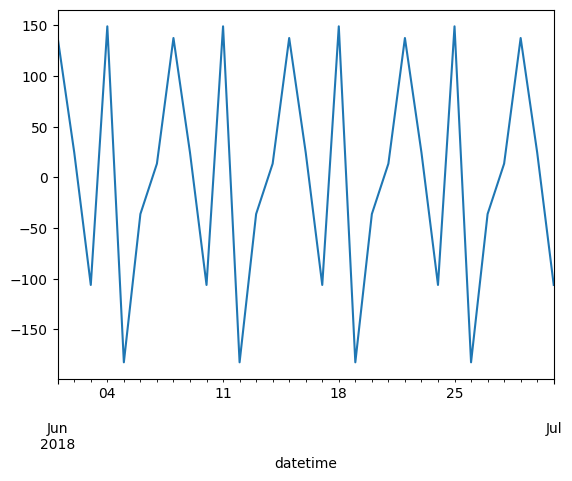

In [24]:
decomposed_week.seasonal['2018-06-01':'2018-07-01'].plot(ax=plt.gca());

В течение недели также присутствует сезонность

Итог:
- В данных присутствует сезонность в течение суток и в течение недели
- Количество заказов увеличивается к осени
- Есть колебания скользящего среднего от дня к дню
- В течение дня скользящее среднее практически не изменяется

## Обучение

In [25]:
rand = 12345

Используем функцию для создания признаков, в которой будут добавлены признаки "месяц", т.к. есть тренд по месяцам, и "день недели", т.к. есть колебания скользящего среднего в течение недели

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [27]:
make_features(data_res,24, 12)

In [28]:
data_res = data_res.drop(['mean', 'std'], axis=1)

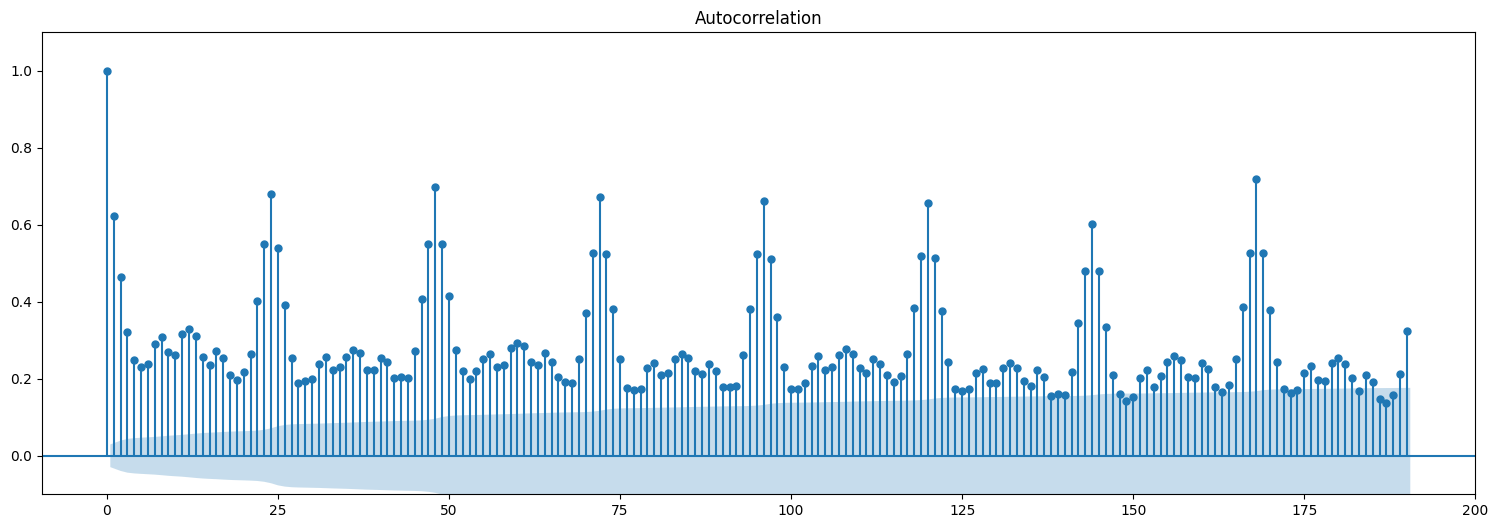

In [29]:
taxi = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Разделим данные на выборки без перемешивания

In [30]:
train, test = train_test_split(data_res, shuffle=False, test_size=0.1)
train = train.dropna()

In [31]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test= test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [32]:
features_train.head(1)

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333


Создадим пайплан для подбора наилучшей модели и параметров для решения задачи обучения

In [33]:
pipe = Pipeline(
    [
        ("regressor", RandomForestRegressor()),
    ]
)

param_grid = [
    {
        "regressor": [LinearRegression()],
    },
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [5, 8, 10, 15],
    },
    {
        "regressor": [RandomForestRegressor(random_state=rand)],
        "regressor__n_estimators": [50, 100, 150],
        "regressor__max_depth": [3, 5, 10, 15],
    },
    {
        "regressor": [lgb.LGBMRegressor(random_state=rand, learning_rate=0.01)],
        "regressor__n_estimators": [50, 100, 150],
        "regressor__max_depth": [3, 5, 10, 15],
    },
    {
        "regressor": [GradientBoostingRegressor(random_state=12345)],
        "regressor__n_estimators": [50, 100, 150],
    }
    
    
]

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=5)
grid.fit(features_train, target_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...................regressor=LinearRegression(); total time=   0.0s
[CV 2/5] END ...................regressor=LinearRegression(); total time=   0.0s
[CV 3/5] END ...................regressor=LinearRegression(); total time=   0.0s
[CV 4/5] END ...................regressor=LinearRegression(); total time=   0.0s
[CV 5/5] END ...................regressor=LinearRegression(); total time=   0.0s
[CV 1/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=5; total time=   0.0s
[CV 2/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=5; total time=   0.0s
[CV 3/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=5; total time=   0.0s
[CV 4/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=5; total time=   0.0s
[CV 5/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=5; total time=   0.0s
[CV 1/5] END regressor=KNeighborsRegressor(), regressor__n_neighbors=8; total 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('regressor', RandomForestRegressor())]),
             param_grid=[{'regressor': [LinearRegression()]},
                         {'regressor': [KNeighborsRegressor()],
                          'regressor__n_neighbors': [5, 8, 10, 15]},
                         {'regressor': [RandomForestRegressor(random_state=12345)],
                          'regressor__max_dept...
                          'regressor__n_estimators': [50, 100, 150]},
                         {'regressor': [LGBMRegressor(learning_rate=0.01,
                                                      random_state=12345)],
                          'regressor__max_depth': [3, 5, 10, 15],
                          'regressor__n_estimators': [50, 100, 150]},
                         {'regressor': [GradientBoostingRegressor(n_estimators=150,
                                                             

In [34]:
print(grid.best_estimator_)
print(-grid.best_score_)

Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(n_estimators=150,
                                           random_state=12345))])
25.060141966835882


Лучшая модель в данном случае - LinearRegression

Итог:
- Данные разделены на обучающую и тестовую выборку
- Подобрана наиболее подходящая модель - LinearRegression 

## Тестирование

Сделаем предсказание и проверим его точность

In [35]:
prediction = grid.best_estimator_.predict(features_test)

Получим значение RMSE

In [36]:
print('RMSE', (mean_squared_error(target_test, prediction, squared=False)))

RMSE 42.183248751854606


Проверим модель на адекватность, сравнив значение ошиьки с предсказанием по предыдущему значению

In [37]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [38]:
print('RMSE', (mean_squared_error(target_test, pred_previous, squared=False)))

RMSE 58.856486242815066


Точность обученной модели гораздо выше, чем у предсказания по предыдущему значению, значит, предсказания не случайные, модель адекватна

Общий итог:
- Данные загружены и обработаны
- Установлены закономерности в данных:сезонность в течение суток, в течение недели, увеличение количества заказов к осени, колебания скользящего среднего от дня к дню
- Произведен подбор моделей и гиперпараметров, наилучшие предсказания получается сделать при помощи LinearRegression
- Модель обучена на данных, достигнуто значение RMSE 8.176376360285602e-13 на тестовой выборке